4410 4410 <class 'numpy.ndarray'>


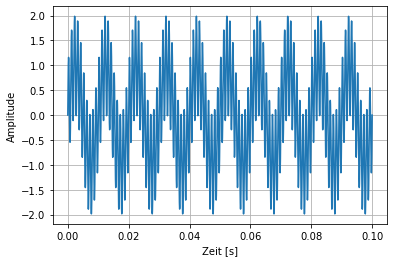

In [26]:
# Test Signal
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt

sampleRate = 44100
T = 0.1

t = np.linspace(0,T,int(sampleRate*T))
x = np.sin(1000 * 2 * np.pi * t) + np.sin(100 * 2 * np.pi * t)

print(len(t), len(x), type(x))
plt.plot(t,x)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [27]:
# Load overlay 
from pynq import Overlay
# ol = Overlay("Matlab_Filter_v2_16.bit")  # max output 2^16 (64 KB), dma 2^16 v.1.8
# ol = Overlay("Matlab_Filter_v2_20.bit")  # max output 2^20 (1 MB), dma 2^26 (max) v.1.9
ol = Overlay("Matlab_Filter_v2_24.bit")  # max output2^24 (16 MB), dma 2^26 (max) v.2.1
# ol = Overlay("Matlab_Filter_v2_26.bit")  # max output 2^26 (64 MB)(max) v.2.0, dma 2^26 (max), timings werden im Design sehr knapp!
# Check IP names
ol.ip_dict.keys()

dict_keys(['axi_dma_0', 'BiquadFil_ip_2_1_0', 'processing_system7_0'])

In [28]:
dma = ol.axi_dma_0
dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel
# allocate Buffer:
from pynq import allocate
import numpy as np
# check status
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)

Error:  False Idle:  False Running:  True


In [29]:
# scalierung des Signals
m = np.max(np.abs(x))                      # Maxwert für Normalisierung
x = x / m                                  # Jetzt liegt x in [-1, 1]
x = x * (2**15)                            # Skalieren auf Q16.16 Bereich (optional leicht unter max)
x = x.astype(np.int32)                     # Als 32-Bit Integer interpretieren
input_data = x.view(np.uint32)             # Für DMA als unsigned darstellen

In [30]:
data_size = int(len(input_data))
input_buffer = allocate(shape=(data_size,), dtype=np.uint32)
input_buffer[:] = input_data

In [31]:
print(input_buffer)

[         0       2576       5104 ... 4294962192 4294964720          0]


In [32]:
# send Buffer
dma_send.transfer(input_buffer)

# Empty Buffer for output
output_buffer = allocate(shape=(data_size,), dtype=np.uint32)

In [33]:
# receive data
dma_recv.transfer(output_buffer)

In [34]:
print(output_buffer)

[   0 1974 3839 ...  831 2676 4491]


In [35]:
output_data = np.array(output_buffer).view(np.int32)  # zurück zu signed int32
y = output_data / (2**15)

4410


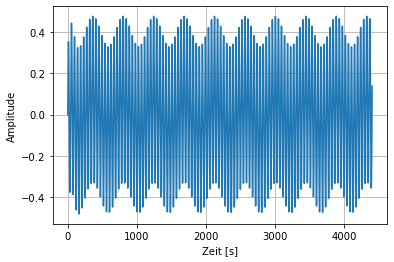

In [36]:
print(len(y))
plt.plot(y)
plt.xlabel("Zeit [s]")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

In [25]:
# clear all buffers
del input_buffer, output_buffer

In [13]:
print("Error: ", dma_recv.error, "Idle: ", dma_recv.idle, "Running: ", dma_recv.running)

Error:  True Idle:  False Running:  False
